In [33]:
from pprint import pprint
import json
import sys
import os
import shutil
from copy import deepcopy
from os.path import join
from importlib import reload

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from keras import callbacks
# from tensorflow.keras import losses
# from tensorflow.keras import metrics
# from tensorflow.keras import optimizers
# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
import tensorflow_addons as tfa

sys.path.insert(0, os.path.join(os.getcwd(), "scs"))
import scs_config
import data_loading as dl
# import data_degrading as dd
# import data_preparation as dp
# import data_augmentation as da
import data_plotting as dplt
import learn
# import lr_schedules
# import models
import hp_sets

In [39]:
def plot_cm(
    cm,
    classes,
    R,
    normalize=True,
    figsize=(12, 9),
    fontsize_offset=5,
    savepath=None
):

    """Normalize confusion matrix and set image parameters"""
    cm = cm.astype("float") / np.nansum(cm, axis=1)[:, np.newaxis]
    off_diag = ~np.eye(cm.shape[0], dtype=bool)
    cm[off_diag] *= -1
    vmin, vmax = -1, 1
    cmap = "RdBu"

    fig = plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="None", cmap=cmap, vmin=vmin, vmax=vmax)

    plt.title(f"R = {R}")

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=23 - fontsize_offset)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15 - fontsize_offset)
    plt.yticks(tick_marks, classes, fontsize=15 - fontsize_offset)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    import itertools
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(abs(cm[i, j]), fmt),
            horizontalalignment="center",
            color="white" if abs(cm[i, j]) > thresh else "black",
            fontsize=18 - fontsize_offset,
        )

    plt.tight_layout()
    plt.ylabel("True label", fontsize=26 - fontsize_offset)
    plt.xlabel("Predicted label", fontsize=26 - fontsize_offset)
    plt.tight_layout()
    plt.savefig(savepath)
    plt.show()


In [40]:
dir_library = "/lustre/lrspec/users/2649/spectralib_v1"
dir_models = "/lustre/lrspec/users/2649/models/transformer_testing"

In [41]:
reload(hp_sets)
R = 100
model_search_name = "dev4"
PG = eval(f"hp_sets.{model_search_name}()")
print(len(PG))

110


In [42]:
keys = []
vals = []
for key, val in PG.param_grid[0].items():
    if len(val) > 1:
        print(key, val)
        keys.append(key)
        vals.append(val)
grids = np.meshgrid(*vals, indexing="ij")
metric_grid_shape = (*grids[0].shape, 6)
metric_grid = np.full(metric_grid_shape, np.nan)

dropout_feed_forward [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
retry [0 1 2 3 4 5 6 7 8 9]


Loaded: /lustre/lrspec/users/2649/models/transformer_testing/100_dev4_33/data/sn_data_trn.RPA.parquet
Loaded: /lustre/lrspec/users/2649/models/transformer_testing/100_dev4_33/data/sn_data_tst.RP.parquet
25/25 [==============================] - 0s 2ms/step


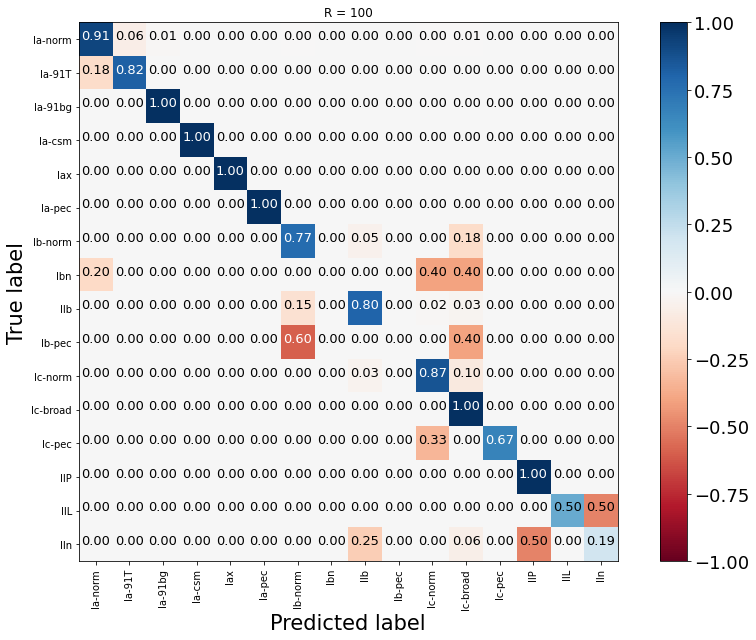

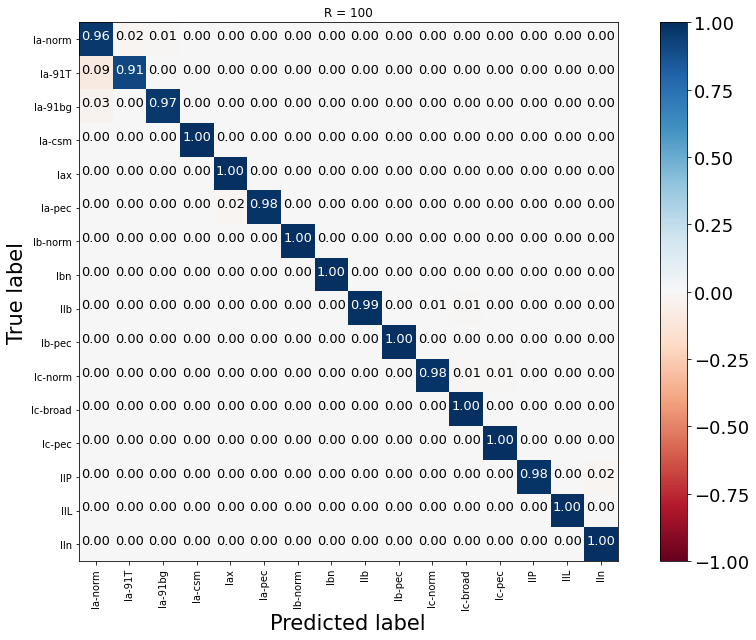

In [43]:
for array_index in range(len(PG)):
    hp = PG[array_index]
    dir_model = join(dir_models, f"{R}_{model_search_name}_{array_index}")

    results_file = join(dir_model, "results.json")
    if not os.path.isfile(results_file):
        continue
    with open(results_file, "r") as f:
        results = json.loads(f.read())
    
    params = []
    for key in keys:
        params.append(hp[key])

    if (params[0] != 0.3) or (params[1] != 3):
        continue
        
    dir_model_data = join(dir_model, "data")
    file_trn = join(dir_model_data, f"sn_data_trn.RPA.parquet")
    file_tst = join(dir_model_data, f"sn_data_tst.RP.parquet")
    
    # Load the dataset.
    df_trn = dl.load_sn_data(file_trn)
    df_tst = dl.load_sn_data(file_tst)
    dataset, num_wvl, num_classes = learn.prepare_datasets_for_training(
        df_trn, df_tst
    )
    Xtrn, Ytrn, Xtst, Ytst = dataset
    
    model = keras.models.load_model(
        join(dir_model, "model.hdf5"),
        custom_objects={"F1Score": tfa.metrics.F1Score(num_classes=num_classes, average="macro", name="f1")})

    Ptrn = model.predict(Xtrn)
    Ptst = model.predict(Xtst)
    
    Ptrn = np.argmax(Ptrn, axis=1)
    Ptst = np.argmax(Ptst, axis=1)
    
    Ytrn = np.argmax(Ytrn, axis=1)
    Ytst = np.argmax(Ytst, axis=1)
    

    SNtypes_int = np.unique(Ytrn)
    SNtypes_str = [scs_config.SN_Stypes_int_to_str[sn] for sn in SNtypes_int]
    
    
    from sklearn.metrics import confusion_matrix
    CMtrn = confusion_matrix(Ytrn, Ptrn)
    CMtst = confusion_matrix(Ytst, Ptst)
    
    plot_cm(CMtst, SNtypes_str, R, normalize=True, savepath="./cm_tst.pdf")
    plot_cm(CMtrn, SNtypes_str, R, normalize=True, savepath="./cm_trn.pdf")